In [1]:
import z3
import numpy as np
from functools import cache
from pprint import pprint
%load_ext line_profiler

from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
sys.path.append('../model/')

import simulation
import analysis
import grammar
reload(simulation)
reload(analysis)
reload(grammar)

<module 'grammar' from '/mnt/c/Users/faust/OneDrive - UvA/research_projects/2024_pLoTRSA/pLOT_RSA/case_studies/../model/grammar.py'>

In [3]:
from Models import BooleanModel
from QUD import ProductQUD
from analysis import parse, already_defined, analyse_specific_hyps, plot_results
from simulation import infer_meaning
from grammar import define_grammar
from utilities import (               
    find_phonform_possible_structures,
    print_possible_utterances         
)

Some generally useful stuff that doesn't really change:

In [4]:
n_props = 2

solver = z3.Solver()

grammar_phon = define_grammar(
    n_props, 
    False
)

grammar_utt = define_grammar(
    n_props, 
    True
)

m = BooleanModel(
    n_props
)

In [17]:
def run_boolean_simulation(s, prob_knows, likelihood_temperature=0.1, prior_temperature=6, n_steps=1e4):
    
    qud = ProductQUD(
        *m.terms, 
        solver=solver, 
        prob_knows=prob_knows
    )
    
    phonform = parse(s, grammar_phon)
    
    print(phonform)

    possible_meanings, utterances_values = find_phonform_possible_structures(
        phonform=phonform,                                                   
        grammar=grammar_utt,                                                 
        qud=qud,                                                             
        model=m,                                                         
        solver=solver,                                                       
        unique=True                                                          
    )      
                                                                             
    print_possible_utterances(                                               
        utterances_values=utterances_values,                                                   
        possible_meanings=possible_meanings,                                                   
        n_props=n_props,                                                             
        solver=solver                                                               
    )         
    
    grammar_belief = define_grammar(
        n_props=n_props, 
        EXH=False, 
        index=len(utterances_values)
    )
    
    tn = infer_meaning(
        qud=qud,
        model=m,
        solver=solver,
        grammar_belief=grammar_belief,
        possible_meanings=possible_meanings,
        likelihood_temperature=likelihood_temperature,
        prior_temperature=prior_temperature,
        n_steps=n_steps
    )
    
    plot_results(
        tn,
        solver
    )

# Model description (OLD, should update!)

The listener computes a joint distribution over QUD-relevant belief states $o$ and possible utterances $u$ given the phonological form $\phi$ (a (partial) answer to the QUD can in principle be inferred from the utterance). We assume a silent EXH operator that does not show in $\phi$ but might be part of $u$. Call $\forall_{EXH}(\phi)$ the set of all utterances compatible with $\phi$.
\begin{align}
P_{L1}(o \mid \phi)
&= \sum_{u \in UTT} P_{L1}(o, u \mid \phi) \\
&= \sum_{u \in UTT} P_{L1}(u \mid \phi)P_{L1}(o \mid u, \phi) \\
&= \frac{1}{|\forall_{EXH}(\phi)|} \sum_{u \in \forall_{EXH}(\phi)} P_{L1}(o \mid u, \phi) & P_{L1}(u \mid \phi) \text{ has uniform prob among compatible \& 0 otherwise} \\
&= \frac{1}{|\forall_{EXH}(\phi)|} \sum_{u \in \forall_{EXH}(\phi)} P_{L1}(o \mid u ) & \text{since $o$ is independent of $\phi$ given $u$} 
\end{align}

At this point we need a way of computing $P_{L1}(o \mid u)$: how probable for the listener is meaning $o$ given utterance $u$? There are many solutions, but here are two:
1. Assume an $S_0$ that samples an utterance uniformly from utterances compatible with the meaning.
2. Assume that the speaker tends to produce an utterance that is more relevant given the QUD. The possible utterances here are the possible parses of the phonological form (given by the various ways of inserting EXH):

\begin{align}
&= \frac{1}{|\forall_{EXH}(\phi)|} \sum_{u \in \forall_{EXH}(\phi)} P_{S1}( [\![ u ]\!] \mid o) P_{L1}(o) K & \text{Bayes' theorem.}
\end{align}

Some points:
- Sample $o$ w/ LOTlib, check with z3 that $o$ is consistent with $u$ (else return -inf), and if so calculate the actual quantities.
- This assumes DAG $o \rightarrow u \rightarrow \phi$, but in future the communicative intention $i$ could be added ($o \rightarrow i \rightarrow u \rightarrow \phi$), which can depend on the speaker's goals independently of the QUD.

At this point we have three components to unpack:
- $\forall_{EXH}(\phi)$
  - The set of utterances compatible with the given phonological form.
- $P_{S1}([\![ u ]\!] \mid o) \propto \texttt{softmax}_\lambda -\text{KL}\left( P_{S1}( A \mid o) ||  P_{L0}( A \mid u) \right)$
    - The (normalized) probability that the speaker will choose an utterance given an observation.
    - The speaker's goal is to answer the QUD as well as possible, and this is of course a function of the meaning of the utterance.
    - $A$ is the random variable "Answer to the QUD"
    - Calculating $P_{S1}( A \mid o)$:
        - The probability of each answer is proportional to the number of models compatible with $o$ that belong to that answer.
    - Calculating $P_{L0}( A | u )) $:
        - In theory, the normalization constant of $P_{L0}(A \mid u)$ is a sum over observations
        - However, since there can be infinitely many possible observations in practice I assume that the literal listener uses an approximation:
        - First, we approximate for each answer $a \in A$ how many models are compatible with $a$. For every answer $a$ sample observations that the meaning is compatible with, up to a MAX, e.g., 10. Call this number $\#_a$. This defines a distribution over answers to the QUD given $o$. Since the QUD partitions the possibilities, a singleton $o$ must provide a single answer, but an $o$ with multiple possible worlds (representing uncertainty) could be compatible with multiple answers.
            - If the QUD is yes/no, we recover a discrete approximation of usual RSA $L0$.
            - This means that the speaker only keeps track of a few observations for each answers to the QUD.
        - Compute a discrete approximation to KL divergence.
        - NOTE: Not adding a cost for conceptual complexity yet, but it would relate to the discussion of conceptual complexity by Buccola.
        - The consequence of this term is that listeners will tend to guess an observations fits closely to the meaning. So for instance meaning "a" (compatible with $b$ and $\neg b$)
- $P_{L1}(o)$
    - The probability of the observation. This is just the prior as induced by the pLoT - dealt with by LOTlib3 (but need to redefine the `prior` function otherwise it'll also include complexity of $m$!)
 
Various to note:
- I assume there's an underlying QUD. The agents have some prior distribution over the answers to the QUD, which depends on their world model.
    - The QUD is modelled as a list of z3 objects, one for each answer to the QUD. For instance the QUD "Who is P?" is represented as: `[ And([P(a),P(b)]), P(a), P(b) ]`
    - This is one way to model a partition of the possible worlds.

This is a model of the interplay of three mechanisms:
- The QUD
- (Unknown) The position of EXH operator
- (Unknown) The speaker's knowledge state

Examples to explain:
- "p" -> "p and not q" w/ QUD="What is true?" w/ the speaker probably knowing whether p and q
- "Not _p_" -> "not p or q" w/ QUD="what is true?" 
- "John talked to Mary or Sue" -> not both (Fox and Spector 2019)
- Suppose that the speaker 



- "Some boys came" -> not all (Fox and Spector 2019)
- "John didn't do the reading OR the homework, he did both" -> not a contradiction! (Fox and Spector 2019)
- "John talked to Mary, or to both Mary and Sue" -> not equivalent to just "Mary" (Trinh 2019)
- Contextual scales:
    - a. A: Do you speak Portuguese? B: My husband's brother does. implicature: B/her husband does not speak Portuguese.
    - (https://www.tandfonline.com/doi/full/10.1080/0163853X.2017.1316038)
- Different focuses:
    - a. A: How many children does Nigel have? B: Nigel has fourteen$_F$ children.
    - b. A: Who has fourteen children? B: Nigel$_F$ has fourteen children.
    - (https://www.tandfonline.com/doi/full/10.1080/0163853X.2017.1316038)

# $p \lor (p \land q)$

## Utterance $(p \land \neg q) \lor (p \land q)$ w/ belief $p$

In [13]:
s = 'lor(p(i0, M), land(p(i1, M), p(i0, M)))'
prob_knows = 0.8

lor(p(i0, M), land(p(i1, M), p(i0, M)))
terms:  [p0, p1] 

lor(EXH(p(i0, M)), land(p(i1, M), p(i0, M)))
	 [p1 = False, p0 = True]
	 [p1 = True, p0 = True]


Synonymy table:
          0
    0 True 



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [00:00<00:00, 1995.38it/s]

{(0, p0): np.float64(5.451818500314078e-08)}


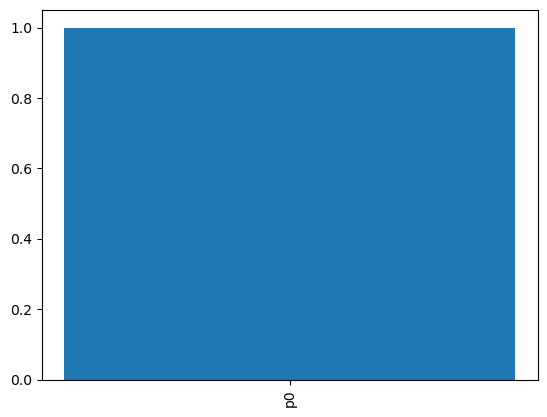

In [14]:
run_boolean_simulation(s, prob_knows)

### Analysis of specific likelihoods

In [11]:
s = 'lor(p(i0, M), land(p(i1, M), p(i0, M)))'
hypotheses = [
    'tuple_(u0, p(i0, M))',
    'tuple_(u0, p(i1, M))',
    'tuple_(u0, lor(p(i1, M), p(i0, M)))',
    'tuple_(u0, land(lnot(p(i1, M)), p(i0, M)))',
    'tuple_(u0, lor(p(i0, M), land(p(i1, M), p(i0, M)))'
]

grammar_phon = define_grammar(
    2, 
    False
)

In [12]:
analyse_specific_hyps(
    s=s,
    hypotheses=hypotheses,
    n_props=n_props,
    grammar_phon=grammar_phon,
    qud=qud,
    temp=5,
    likelihood_temperature=0.1,
    prior_temperature=6,
    print_log=True,
)

terms:  [p0, p1] 

lor(EXH(p(i0, M)), land(p(i1, M), p(i0, M)))
	 [p1 = False, p0 = True]
	 [p1 = True, p0 = True]


Synonymy table:
          0
    0 True 



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 540.27it/s]


----------
hyp:  lambda M: tuple_(u0, p(i0, M))
qud:  <QUD.ProductQUD object at 0x7f117d6f2c90>
util: 0.0
exp KL:  1.0
prob belief:  0.1538461538461538
total lik:  0.1538461538461538

----------
hyp:  lambda M: tuple_(u0, p(i1, M))
qud:  <QUD.ProductQUD object at 0x7f117d6f2c90>
util: -inf
exp KL:  0.0
inconsistent prob:  0.0


----------
hyp:  lambda M: tuple_(u0, lor(p(i1, M), p(i0, M)))
qud:  <QUD.ProductQUD object at 0x7f117d6f2c90>
util: -inf
exp KL:  0.0
inconsistent prob:  0.0


----------
hyp:  lambda M: tuple_(u0, land(lnot(p(i1, M)), p(i0, M)))
qud:  <QUD.ProductQUD object at 0x7f117d6f2c90>
util: -0.6931471805599453
exp KL:  0.03125
prob belief:  0.4102564102564103
total lik:  0.012820512820512822

----------
hyp:  lambda M: tuple_(u0, lor(p(i0, M), land(p(i1, M), p(i0, M))))
qud:  <QUD.ProductQUD object at 0x7f117d6f2c90>
util: 0.0
exp KL:  1.0
prob belief:  0.1538461538461538
total lik:  0.1538461538461538


{lambda M: tuple_(u0, p(i0, M)): -19.016648347220592,
 lambda M: tuple_(u0, p(i1, M)): -92.40203029796761,
 lambda M: tuple_(u0, lor(p(i1, M), p(i0, M))): -93.151998576356,
 lambda M: tuple_(u0, land(lnot(p(i1, M)), p(i0, M))): -44.95150029357934,
 lambda M: tuple_(u0, lor(p(i0, M), land(p(i1, M), p(i0, M)))): -20.516584903997348}

Problem:
- An utterance of 'p or (p and q)' might be (among others):
    1. A non exhaustified utterance meaning 'p', with speaker's belief 'p' (UNLIKELY)
    2. An exhaustified utterance 'EXH(p) or (p and q)', with speaker's belief '(p and not q) or (p and q)' -> 'p' (Ignorance implicature)
- The point of the example is that to express just belief state 'p', a speaker would use this longer expression rather than just saying 'p'.

# $p$

In [6]:
s = 'p(i0, M)'

p(i0, M)


## High p_know: utterance 'p and not q' w/ belief 'p and not q'

In [11]:
prob_knows = 0.9

p(i0, M)
terms:  [p0, p1] 

p(i0, M)
	 [p0 = True]
	 [p1 = True, p0 = True]


EXH(p(i0, M))
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 832/832 [00:00<00:00, 1514.40it/s]


{(0, Not(p0)): np.float64(6.609010760532878e-51),
 (0, And(p1, p0)): np.float64(4.102648262587442e-18),
 (0, Not(Implies(Not(p0), p1))): np.float64(2.2314431668390045e-51),
 (0, p0): np.float64(5.697562896669402e-13),
 (0, Not(p1)): np.float64(6.609010760532878e-51),
 (1, And(Not(Not(p0)), Not(p1))): np.float64(0.06605953500543775)}


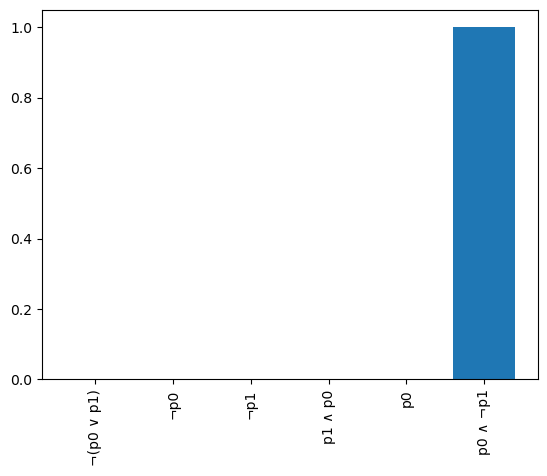

In [12]:
run_boolean_simulation(s, prob_knows)

Problem:
- An utterance of 'p' (w/ QUD: 'whether p and whether q') might be any of:
    1. An exhaustified utterance meaning 'p and not q', with speaker's belief = 'p and not q'
    1. A partial description of the speaker's belief, with speaker's belief = 'p and q'
    1. A full description of the speaker's belief, with speaker's belief = 'p'
- The RSA strategy explains why if the belief is 'p and not q', the speaker would use the exhaustified utterance rather than the non-exhaustified one (relevant to 1.)
- The LOT component models partial beliefs (relevant to 3.)
- However, there is at the moment no mechanism that leads S1 to answering the QUD as much as possible given the belief state. This would need to be added manually.
    - This is related to what RSA does naturally with full utterance space, namely: convey as much information as possible. But it is not quite the same as RSA, because it does not depend on the specific available utterances.
    - It is captured implicitly in the KL divergence before normalization, since that gives an absolute measure of how similar the listener's beliefs become to the speaker's upon hearing the utterance.
    - So, I could use the _expected_ KL divergence? But what's the _interpretation_ of that?

## Low p_know: utterance 'p' w/ belief 'p' (ignorance implicature wrt q)

In [23]:
prob_knows = 0.3

p(i1, M)


p(i0, M)
terms:  [p0, p1] 

p(i0, M)
	 [p0 = True]
	 [p1 = True, p0 = True]


EXH(p(i0, M))
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 2058.07it/s]


{(0, Not(p1)): np.float64(6.609010760532878e-51),
 (0, p0): np.float64(1.1629045409777195e-12)}


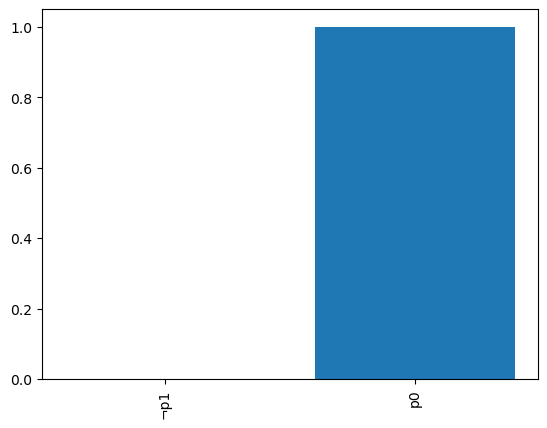

In [13]:
run_boolean_simulation(s, prob_knows)

# $p \lor q$

In [18]:
s = 'lor( p(i0, M), p(i1, M) )'

## High p_know: utterance $EXH(p \lor q)$ w/ belief $(p \lor q) \land \neg(p \land q)$

In [19]:
prob_knows = 0.9

lor(p(i0, M), p(i1, M))
terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = False, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000.0 [04:19<00:00, 192.74it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2261/2261 [00:01<00:00, 1353.32it/s]


{(0, And(p1, Not(p1))): np.float64(3.121974662478175e-51),
 (0, p1): np.float64(2.6590040163734184e-22),
 (0, p0): np.float64(2.7632703144946926e-22),
 (0, And(p0, Not(p1))): np.float64(6.434300382295992e-27),
 (1, And(Implies(p0, Not(p1)), Implies(Not(p1), p0))): np.float64(5.479659228125989e-13),
 (1, And(Implies(And(Not(p0), Not(p1)), p0), Not(p0))): np.float64(1.739549850468676e-16),
 (1, And(p0, Not(p1))): np.float64(1.5002198092619783e-16)}


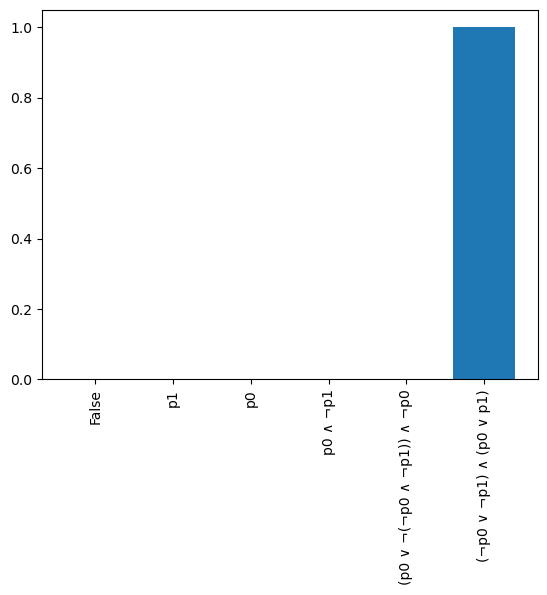

In [20]:
run_boolean_simulation(s, prob_knows, n_steps=5*1e4)

### Enumerative approximation

In [7]:
hypotheses = [
    'tuple_(u0, p(i0, M))',
    'tuple_(u0, (p(i1, M))',
    'tuple_(u1, leitheror(p(i0, M),p(i1, M)))',
    'tuple_(u0, lor(p(i0, M),p(i1, M))',
    'tuple_(u1, land(p(i0, M), lnot(p(i1, M)))',
    'tuple_(u1, land(lor(p(i0, M), p(i1, M)), lnot(land(p(i0, M), p(i1, M))))'
]

In [8]:
possible_hypotheses = list(grammar_belief.enumerate(5))

In [9]:
len(possible_hypotheses)

18936

In [10]:
posterior_scores = analyse_specific_hyps(
    s=s,
    hypotheses=possible_hypotheses,
    n_props=2,
    grammar_phon=grammar_phon,
    qud=qud,
    temp=3,
    likelihood_temperature=0.1,
    prior_temperature=6,
    print_log=False
)

terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p0 = True]
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18936/18936 [00:25<00:00, 743.93it/s]


  8%|██████████                                                                                                                     | 1500/18936 [00:41<07:59, 36.33it/s]


{(1, Or(Not(Or(p1, Not(p0))), And(Not(p0), p1))): np.float64(0.0004090751935660656), (0, Or(p0, p1)): np.float64(9.93761145906093e-05), (0, p1): np.float64(2.2970113145263278e-08), (0, p0): np.float64(2.22462925322201e-08), (0, Or(Not(Or(p1, Not(p0))), And(Not(p0), p1))): np.float64(1.142874652173473e-09)}


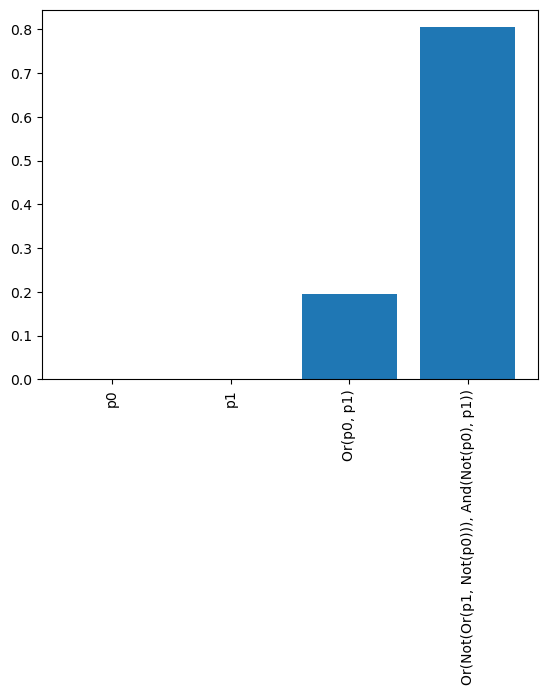

In [11]:
plot_results(posterior_scores, dict_type='scores', first_n=1500)

### Specific likelihoods

In [12]:
hypotheses = [
    'tuple_(u0, p(i0, M))',
    'tuple_(u0, (p(i1, M))',
    'tuple_(u0, lor(p(i0, M),p(i1, M))',
    'tuple_(u1, land(p(i0, M), lnot(p(i1, M)))',
    'tuple_(u1, land(lor(p(i0, M), p(i1, M)), lnot(land(p(i0, M), p(i1, M))))'
]

In [13]:
analyse_specific_hyps(
    s, 
    hypotheses, 
    n_props, 
    grammar_phon, 
    qud=qud,
    # hypothesis kwargs
    temp=5,
    likelihood_temperature=0.1,
    prior_temperature=6,
)

terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p0 = True]
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 412.96it/s]


----------
hyp:  lambda M: tuple_(u0, p(i0, M))
qud:  <QUD.ProductQUD object at 0x7f3958671730>
util: -0.4054651081081645
exp KL:  0.1316872427983538
prob belief:  0.4
total lik:  0.05267489711934153

----------
hyp:  lambda M: tuple_(u0, p(i1, M))
qud:  <QUD.ProductQUD object at 0x7f3958671730>
util: -0.4054651081081645
exp KL:  0.1316872427983538
prob belief:  0.4
total lik:  0.05267489711934153

----------
hyp:  lambda M: tuple_(u0, lor(p(i0, M), p(i1, M)))
qud:  <QUD.ProductQUD object at 0x7f3958671730>
util: 0.0
exp KL:  1.0
prob belief:  0.26666666666666666
total lik:  0.26666666666666666

----------
hyp:  lambda M: tuple_(u1, land(p(i0, M), lnot(p(i1, M))))
qud:  <QUD.ProductQUD object at 0x7f3958671730>
util: -0.6931471805599453
exp KL:  0.03125
prob belief:  0.06666666666666667
total lik:  0.0020833333333333333

----------
hyp:  lambda M: tuple_(u1, land(lor(p(i0, M), p(i1, M)), lnot(land(p(i0, M), p(i1, M)))))
qud:  <QUD.ProductQUD object at 0x7f3958671730>
util: 0.0
exp KL:

{lambda M: tuple_(u0, p(i0, M)): -29.850313832447775,
 lambda M: tuple_(u0, p(i1, M)): -29.850313832447775,
 lambda M: tuple_(u0, lor(p(i0, M), p(i1, M))): -14.38167778650957,
 lambda M: tuple_(u1, land(p(i0, M), lnot(p(i1, M)))): -63.23779759579612,
 lambda M: tuple_(u1, land(lor(p(i0, M), p(i1, M)), lnot(land(p(i0, M), p(i1, M))))): -12.162780432295058}

## Low p_know: utterance $p \lor q$ w/ belief $p \lor q$

In [21]:
prob_knows = 0.1

lor(p(i0, M), p(i1, M))
terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = False, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000.0 [04:30<00:00, 184.86it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4141/4141 [00:01<00:00, 2224.98it/s]


{(0, p1): np.float64(5.6469794531435875e-18),
 (0, Implies(Not(p0), p1)): np.float64(10.845506217696983),
 (0, Not(Not(p0))): np.float64(2.3538072528153e-18),
 (0, Not(p0)): np.float64(6.609010760532878e-51),
 (1, Or(Not(Not(p1)), p1)): np.float64(2.2314431668390045e-51),
 (1, Not(p0)): np.float64(6.609010760532878e-51)}


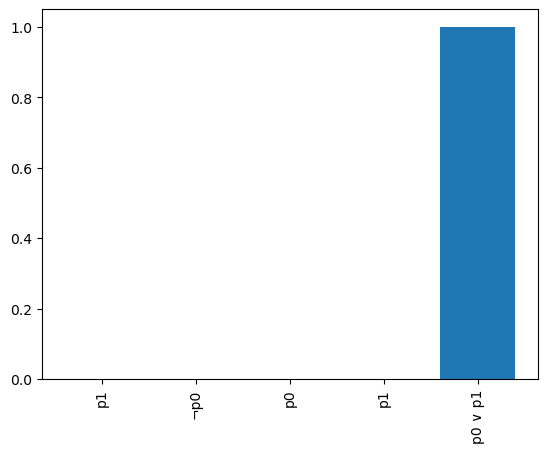

In [22]:
run_boolean_simulation(s, prob_knows)

Low range of P(knows):
- P(knows) $< 0.10$: best is belief state 'p or q'
- The following two have the same _likelihood_:
    - Belief "p or q" under utterance "p or q"
    - Belief "(p or q) and not(p and q)" under utterance "EXH(p or q)".
- Because they are equivalent wrt the two components of the likelihood:
    - They fully convey the respective beliefs (KL=0) 
    - They imply neither p nor q.
- However, 'p or q' "wins" because it has a higher prior probability.
- Correct prediction: If the p(know each prop) is low, bare 'p or q' (but doesn't know which) is a plausible interpretation.

Mid range of P(knows)
- P(knows) $(0.10,0.95)$: best are 'p', 'q'
- Desired but unrealized prediction:
    - For the mid range of p(know each prop) the "(p or q) and not(p and q)" interpretation should become most likely
        - This is an ignorance implicature meaning: "Exactly one is true, but I don't know which one"
    - The 'full knowledge' interpretations ('p and not q', 'q and not p') would be too strange to be right
        - These are: 'p and not q' and 'not p and q' under the utterance 'EXH(p or q)'
        - What is strange for real speakers about the 'full knowledge' interpretations given phonform 'p or q'?
            - If belief state was 'p and not q', they would not say 'EXH(p or q)', because 'EXH(p or q)' leaves a false state open (namely, p=False and q=True).
    - The 'partial beliefs' interpretations ('p' and 'q', under utterance 'p or q') _should_ be implausible for this mid range
        - If belief state was 'p', the speaker would just convey 'p'.
        - Saying 'p or q' leaves a false state open (p=False, q=True).
- The core of the problem:
    - Belief state "(p or q) and not(p and q)" has the same prob as "p or q"
    - But the former might be more probable in context! For instance if I expect the speaker to have at least some information.
    - This suggests a more sophisticated encoding for the listener's prior over belief states.
    - At the moment, this is just $\prod_i P(k_i)$, with $\forall i k_i = \beta$
    - I want instead a prior where _excluding_ some possibilities gives a higher probability.

Very high range of P(knows):
- P(knows) $> 0.95$: best are 'p and not q', 'q and not p' under utterance 'EXH(p or q)'
- Correct prediction: If the p(know each prop) is high enough, 'p or q' is interpreted as the speaker knowing that only one is true, but not saying which one.
- This means "Exactly one is true, but I'm not telling you which"